In this notebook, we will demonstrate and compare the results for image classification on the CIFAR10 dataset on the CNNs AlexNet and VGG19 with different approaches. We will visualize where the focus for both nets lay with class activation maps in the second part. \\

First of all, you need to clone our repository:

In [48]:
!git clone https://github.com/Sascha0912/DL_CIFAR.git

fatal: destination path 'DL_CIFAR' already exists and is not an empty directory.


In [49]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torchvision.models import alexnet
from torchvision.models import vgg19

# CIFAR10 datatset
This dataset contains 60,000 images of size 32x32. There is a total of 10 classes, in the dataset are 6,000 images for each class. In total, ... are used for the training phase, the remaining will be used for testing.

## Image preprocessing
For both models AlexNet and VGG19, the input images have to be at least of size 224x224. Hence, all images from the dataset need to be resized first. In some use cases, the input images are also cropped because the main information for the net usually lies in the center of the image. We will use two transform operations and find out if there is a siginificant difference in performance.

In [50]:
transform_normal = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transform_centercrop = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Downloading data with both transformation operations
# normal
test_data_n = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_normal)
testloader_n = torch.utils.data.DataLoader(test_data_n, batch_size=24, shuffle=False, num_workers=2)
# with centercrop
test_data_cc = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_centercrop)
testloader_cc = torch.utils.data.DataLoader(test_data_cc, batch_size=24, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


# CNN Models: AlexNet and VGG19

## Architecture

To implement the freezing for a custom number of layer, we wrote a custom class for both models. They use the features of the `torchvision.models`. We cannot use the same classifiers as well, since for the class activation maps later only one linear layer at the end is allowed. Therefore, we are writing our custom nets which are based on the original architectures.



In [51]:
class Alexnet(nn.Module):
    def __init__(self, pretrained = False, freeze = None):
        super().__init__()
        # get the pretrained AlexNet network
        alex_net = alexnet(pretrained = pretrained)
        self.features = alex_net.features
        self.avg_pool = alex_net.avgpool
        self.classifier = nn.Linear(256, 10)

        if(freeze):
          for i, param in enumerate(self.features.parameters()):
            param.requires_grad = False
            if(i+1 >= freeze):
              break
        
    def forward(self, x):
        x = self.features(x)
        x = self.avg_pool(x)
        batch_size = x.shape[0]
        x = x.view(batch_size, 256, -1)
        x = x.mean(2)
        x = self.classifier(x)
        return x

class Vgg19(nn.Module):
    def __init__(self, pretrained = False, freeze = None):
        super().__init__()
        # get the pretrained Vgg19_bn network
        vgg19_net = vgg19(pretrained = pretrained)
        self.features = vgg19_net.features
        self.avg_pool = vgg19_net.avgpool
        self.classifier = nn.Linear(512,10)

        if(freeze):
          for i, param in enumerate(self.features.parameters()):
            param.requires_grad = False
            if(i+1 >= freeze):
              break
        
    def forward(self, x):
        x = self.features(x)
        x = self.avg_pool(x)
        batch_size = x.shape[0]
        x = x.view(batch_size, 512, -1)
        x = x.mean(2)
        x = self.classifier(x)
        return x

## Loading Models from Github Repository
Since training the models several time takes some time, we will load our pretrained models from the repository. For both the AlexNet and VGG19, we used the following variations:

*   all features with weights initialized randomly
*   all features with pretrained weights from ImageNet
*   1/4 of the first layers are frozen and with pretrained weights from ImageNet
*   2/4 of the first layers are frozen and with pretrained weights from ImageNet
*   3/4 of the first layers are frozen and with pretrained weights from ImageNet

For all models we used the following hyperparameters:
* Epochs: 10
* Learning rate: 0.0001

# Calculate and Evaluate Accuracies
For the following evaluations we will use this test function which computes the accuracy of a given net.

In [52]:
def test_net(net, testloader):
  correct = 0
  total = 0
  with torch.no_grad():
      for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        if total > 100:
          break
  return correct / total

#Class labels
classes = ('Airplane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck')
#Testing classification accuracy for individual classes.
def test_classes(net, testloader):
  class_correct = list(0. for i in range(10))
  class_total = list(0. for i in range(10))
  with torch.no_grad():
      for data in testloader:
          images, labels = data[0].to(device), data[1].to(device)
          outputs = net(images)
          _, predicted = torch.max(outputs, 1)
          c = (predicted == labels).squeeze()
          for i in range(4):
              label = labels[i]
              class_correct[label] += c[i].item()
              class_total[label] += 1
  for i in range(10):
      print('Accuracy of %5s : %2.1f' % (
          classes[i], 100 * class_correct[i] / class_total[i]))

In [53]:
alexNet = Alexnet()
vgg = Vgg19()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
alexNet.to(device)
vgg.to(device)

Vgg19(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), pa

## Image Centercrop vs. without Centercrop
The first test results show the impact of center cropping the images:

In [54]:
alexNet.load_state_dict(torch.load( '/content/DL_CIFAR/models/centercropped/alexnet_CenterCrop.pth' ))
vgg.load_state_dict(torch.load( '/content/DL_CIFAR/models/centercropped/vgg19_CenterCrop.pth' ))
alexnet_result_centercrop = test_net(alexNet, testloader_cc)
vgg_result_centercrop = test_net(vgg, testloader_cc)

alexNet.load_state_dict(torch.load( '/content/DL_CIFAR/models/centercropped/alexnet_noCenterCrop.pth' ))
vgg.load_state_dict(torch.load( '/content/DL_CIFAR/models/centercropped/vgg19_noCenterCrop.pth' ))
alexnet_result_nocentercrop = test_net(alexNet, testloader_n)
vgg_result_nocentercrop = test_net(vgg, testloader_n)

print('Accuracy of AlexNet on centercropped images is %2.1f, without centercrop is %2.1f'
      % (alexnet_result_centercrop, alexnet_result_nocentercrop))
print('Accuracy of VGG19 on centercropped images is %2.1f, without centercrop is %2.1f'
      % (vgg_result_centercrop, vgg_result_nocentercrop))

Accuracy of AlexNet on centercropped images is 0.9, without centercrop is 0.9
Accuracy of VGG19 on centercropped images is 0.9, without centercrop is 1.0


## Pretrained weights vs. random initialized weights

In [55]:
alexNet.load_state_dict(torch.load( '/content/DL_CIFAR/models/Pretraining/alexnet_pretrained.pth' ))
vgg.load_state_dict(torch.load( '/content/DL_CIFAR/models/Pretraining/cifar_vgg_pretrained.pth' ))
alexnet_result_pretrained = test_net(alexNet, testloader_n)
vgg_result_pretrained = test_net(vgg, testloader_n)

alexNet.load_state_dict(torch.load( '/content/DL_CIFAR/models/Pretraining/alexnet_not_pretrained.pth' ))
vgg.load_state_dict(torch.load( '/content/DL_CIFAR/models/Pretraining/cifar_vgg_not_pretrained.pth' ))
alexnet_result_not_pretrained = test_net(alexNet, testloader_n)
vgg_result_not_pretrained = test_net(vgg, testloader_n)

print('Accuracy of AlexNet with pretrained weights is %2.1f, with random initialized weights is %2.1f'
      % (alexnet_result_pretrained, alexnet_result_not_pretrained))
print('Accuracy of VGG19 with pretrained weights is %2.1f, with random initialized weights is %2.1f'
      % (vgg_result_pretrained, vgg_result_not_pretrained))


Accuracy of AlexNet with pretrained weights is 0.9, with random initialized weights is 0.5
Accuracy of VGG19 with pretrained weights is 0.1, with random initialized weights is 0.6


The accuracy difference for AlexNet as well as VGG19 is quite bit. If we take a closer look on the training process, we see that the nets with pretrained weights learn far faster than with random initialized weights. In the diagram below can see the loss for the first 10 epochs of learning.

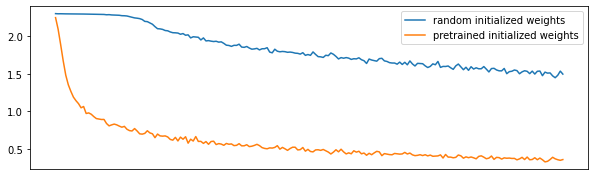

In [56]:
a_p = [2.2510,2.0970,1.8908,1.6739,1.4835,1.3551,1.2675,1.1908,1.1429,1.1034,1.0480,1.0649,0.9720,0.9797,0.9617,0.9303,0.9040,0.8985,0.8918,0.8926	,
0.8379,0.8068,0.8198,0.8304,0.8201,0.8035,0.7889,0.8000,0.7617,0.7434,0.7385,0.7708,0.7382,0.7004,0.6962,0.7063,0.7415,0.7130,0.7008,0.6492	,
0.6971,0.6729,0.6694,0.6727,0.6587,0.6257,0.6160,0.6532,0.6055,0.6566,0.6282,0.6616,0.5760,0.6288,0.6044,0.6641,0.5990,0.6000,0.5729,0.5969	,
0.5609,0.5978,0.6020,0.5575,0.5700,0.5636,0.5472,0.5720,0.5613,0.5657,0.5432,0.5469,0.5689,0.5401,0.5407,0.5551,0.5300,0.5352,0.5462,0.5604	,
0.5430,0.5167,0.5059,0.5008,0.5128,0.5102,0.5190,0.5423,0.4958,0.5191,0.5007,0.4800,0.5042,0.5218,0.5217,0.4855,0.4896,0.5179,0.4691,0.4931	,
0.4647,0.4596,0.4859,0.4879,0.4797,0.4918,0.4744,0.4570,0.4315,0.4561,0.4879,0.4603,0.4950,0.4595,0.4324,0.4466,0.4341,0.4744,0.4561,0.4678	,
0.4337,0.4441,0.4144,0.4406,0.4219,0.4460,0.4668,0.4596,0.4092,0.4365,0.4292,0.4233,0.4211,0.4384,0.4346,0.4296,0.4321,0.4526,0.4314,0.4440	,
0.4201,0.4093,0.4134,0.4217,0.4104,0.4214,0.4062,0.4169,0.4009,0.4028,0.4057,0.4196,0.3777,0.4249,0.3899,0.3896,0.3807,0.3865,0.4180,0.4069	,
0.3754,0.3931,0.3819,0.3914,0.3806,0.3670,0.3993,0.4068,0.3889,0.3679,0.3765,0.4043,0.3596,0.3863,0.3829,0.3632,0.3798,0.3746,0.3770,0.3719	,
0.3727,0.3535,0.3658,0.3868,0.3572,0.3905,0.3545,0.3578,0.3813,0.3548,0.3772,0.3545,0.3260,0.3336,0.3576,0.3875,0.3669,0.3550,0.3470,0.3569	
]
a_np = [2.3044,2.3023,2.3029,2.3018,2.3013,2.3011,2.3014,2.3004,2.3004,2.3009,2.2990,2.2989,2.2981,2.2981,2.2977,2.2968,2.2954,2.2948,2.2938,2.2934	,
2.2892,2.2909,2.2869,2.2848,2.2840,2.2825,2.2770,2.2761,2.2730,2.2641,2.2544,2.2474,2.2435,2.2377,2.2258,2.2009,2.1977,2.1797,2.1629,2.1308	,
2.1033,2.1008,2.0941,2.0790,2.0753,2.0598,2.0498,2.0484,2.0452,2.0291,2.0383,2.0160,2.0215,1.9805,1.9958,1.9918,1.9888,1.9531,1.9805,1.9400	,
1.9444,1.9371,1.9320,1.9357,1.9241,1.9279,1.9076,1.8834,1.8796,1.8676,1.8816,1.8807,1.8967,1.8582,1.8545,1.8658,1.8454,1.8299,1.8339,1.8412	,
1.8202,1.8356,1.8363,1.8498,1.7914,1.7815,1.8296,1.8029,1.7953,1.7997,1.7968,1.7885,1.7916,1.7865,1.7772,1.7745,1.7644,1.7831,1.7478,1.7587	,
1.7479,1.7934,1.7603,1.7306,1.7280,1.7197,1.7489,1.7435,1.7796,1.7619,1.7335,1.6998,1.7175,1.7093,1.7178,1.7105,1.6935,1.7026,1.7002,1.7152	,
1.6896,1.6761,1.6392,1.6985,1.6853,1.6773,1.6698,1.7038,1.7083,1.6739,1.6665,1.6502,1.6454,1.6452,1.6300,1.6575,1.6261,1.6549,1.6218,1.6732	,
1.6331,1.6059,1.6410,1.6392,1.6362,1.6077,1.5852,1.6005,1.6341,1.6223,1.6664,1.5869,1.6001,1.5991,1.6057,1.5818,1.5609,1.6071,1.6318,1.5931	,
1.5561,1.5887,1.5480,1.5959,1.5650,1.5815,1.5684,1.5688,1.5981,1.5634,1.5263,1.5716,1.5747,1.5526,1.5413,1.5406,1.5728,1.5031,1.5302,1.5354	,
1.5523,1.5440,1.5021,1.5272,1.5421,1.5348,1.5035,1.5373,1.4979,1.5352,1.5383,1.4764,1.5238,1.5105,1.5132,1.4737,1.4490,1.4816,1.5371,1.4975	,
]

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10,3))
plt.plot(a_np, label='random initialized weights')
plt.plot(a_p, label='pretrained initialized weights')
plt.legend()
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
plt.show()

## Freezing of different amount of layers
Frozen layers have fixed weights that will not be adapted within the training process. They do not take part in the backpropagation. Utilizing this technique can significantly reduce computational time. However, freezing Layers have a negative impact on the accuracies since not all weights are modified. 

The following barchart shows the differences in computation time the training process consumes. The time has been tracked using cuda events on Google Colab ressources.

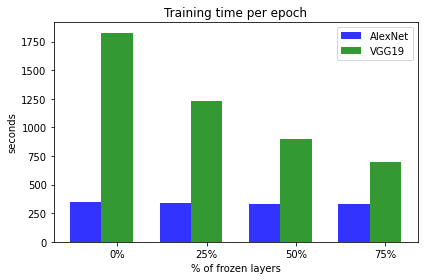

In [57]:
n_groups = 4
times_alex = (350,343,331,330)
times_vgg19 = (1827,1229,900,698)

fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, times_alex, bar_width,
alpha=opacity,
color='b',
label='AlexNet')

rects2 = plt.bar(index + bar_width, times_vgg19, bar_width,
alpha=opacity,
color='g',
label='VGG19')

plt.xlabel('% of frozen layers')
plt.ylabel('seconds')
plt.title('Training time per epoch')
plt.xticks(index + bar_width, ('0%', '25%', '50%', '75%'))
plt.legend()

plt.tight_layout()
plt.show()


In the diagram we can see that AlexNet reduces the time of training only up to 5.5\% whilst VGG19 speeds up to 61.7\% comparing the times of no freezed layers and 75\% of freezed layers. Thus training VGG19 only takes two times longer with 75\% of layer freezing instead of six times longer without layer freezing. Both architectures show that freezing prior layers save more time per layer then later layers.

The second barchart shows the impact on the accuracy.

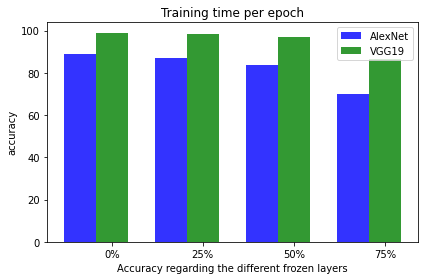

In [58]:
n_groups = 4
times_alex = (88.658,87.108,83.492,70.084)
times_vgg19 = (98.9,98.476,96.752,86.452)

fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, times_alex, bar_width,
alpha=opacity,
color='b',
label='AlexNet')

rects2 = plt.bar(index + bar_width, times_vgg19, bar_width,
alpha=opacity,
color='g',
label='VGG19')

plt.xlabel('Accuracy regarding the different frozen layers')
plt.ylabel('accuracy')
plt.title('Training time per epoch')
plt.xticks(index + bar_width, ('0%', '25%', '50%', '75%'))
plt.legend()

plt.tight_layout()
plt.show()

Both architectures loose accuracy with an increasing number of frozen layers. VGG19 looses less accuracy what might be due the larger amount of convolutional layers in total.

## AlexNet vs. VGG19


In [59]:
print('Accuracy of AlexNet with pretrained weights %2.1f' % alexnet_result_pretrained)
print('Accuracy of VGG19 with pretrained weights %2.1f' % vgg_result_pretrained)

Accuracy of AlexNet with pretrained weights 0.9
Accuracy of VGG19 with pretrained weights 0.1


In the previous sections we have already computed several accuracies for both AlexNet and VGG19. It is easy to see that in all cases the VGG19 models have a higher accuracy than the AlexNet models. This indicates that it is the superior design, and that the additional depth that VGG19 boasts over AlexNet is indeed useful. This comes at a cost however as training VGG19 takes longer than AlexNet to train and results in a larger model. 

## Class Accuracies

In [60]:
alexNet.load_state_dict(torch.load( '/content/DL_CIFAR/models/Pretraining/alexnet_pretrained.pth' ))
vgg.load_state_dict(torch.load( '/content/DL_CIFAR/models/Pretraining/cifar_vgg_pretrained.pth' ))

print('Class acccuracies of AlexNet with pretrained weights')
test_classes(alexNet, testloader_n)
print('Class acccuracies of VGG19 with pretrained weights')
test_classes(vgg, testloader_n)

Class acccuracies of AlexNet with pretrained weights
Accuracy of Airplane : 77.8
Accuracy of   Car : 84.2
Accuracy of  Bird : 76.4
Accuracy of   Cat : 73.9
Accuracy of  Deer : 84.5
Accuracy of   Dog : 82.6
Accuracy of  Frog : 95.2
Accuracy of Horse : 89.5
Accuracy of  Ship : 94.7
Accuracy of Truck : 94.9
Class acccuracies of VGG19 with pretrained weights
Accuracy of Airplane : 0.6
Accuracy of   Car : 100.0
Accuracy of  Bird : 0.0
Accuracy of   Cat : 2.0
Accuracy of  Deer : 0.0
Accuracy of   Dog : 0.0
Accuracy of  Frog : 0.0
Accuracy of Horse : 0.0
Accuracy of  Ship : 0.0
Accuracy of Truck : 0.6


In general VGG19 remains the superior net, and on average has a higher class accuracy than AlexNet. 

With different training applied to the architecture a couple of patterns seem to emerge. VGG19 class accuracy's are generally more homogeneous than AlexNets. 

Another pattern that seems to emerge is that AlexNet between visually similar classes tends to favor one over the other. It is either good at detecting cats or dogs, it is good at detecting horses or deer. This effect becomes more pronounced as accuracy decreases. This could indicate that the general discriminatory region identified by the model is correct but that it lacks the ability to separate similar things.

# Class Activation Maps

Execute the following four code blocks. The blocks contain required functions, classes and imports.

The returnCAM function is the function responsible for generating the CAMs. The function accepts the output of the lats convolutional layer as well as the weights of the softmax layer to generate the output image.

The preprocessTestImages transforms the elements in our CIFAR10 dataset by Resizing the input images and normalize the corresponding tensors to have a specific mean and standard deviation.

The UnNormalize function will undo the Normalization of the preprocess function to retrieve the original images back at the end.

In [61]:
import cv2
from torchvision.utils import save_image
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [62]:
def returnCAM(feature_conv, weight_softmax, class_idx):
    size_upsample = (256, 256)
    bz, nc, h, w = feature_conv.shape
    output_cam = []
    for idx in class_idx:
        beforeDot =  feature_conv.reshape((nc, h*w))
        cam = np.matmul(weight_softmax[idx], beforeDot)
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(cv2.resize(cam_img, size_upsample))
    return output_cam

In [63]:
def preprocessTestImages():
    normalize = transforms.Normalize(
       mean=[0.485, 0.456, 0.406],
       std=[0.229, 0.224, 0.225]
    )
    preprocess = transforms.Compose([
       transforms.Resize((224,224)),
       transforms.ToTensor(),
       normalize
    ])
    return preprocess

In [64]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

## Image Centercrop vs. without Centercrop

Execute the follwing code block to generate the CAM images. 

In the code, we create four different models:
1. VGG19 (without Centercrop)
2. VGG19 (with Centercrop)
3. Alexnet (without Centercrop)
4. Alexnet (with Centercrop)

Basic procedure:
1. Load Models from the files
2. Set the models to evaluation mode
3. Create a testloader with one (random) image
4. get the logits of the models (forward step)
5. get the probs and the indices of the last (softmax) layer
6. get the outputs of the last convolutional layer and apply Global Average Pooling
7. Put the weights of the softmax layer and the convolutional output into the returnCAM function
8. Process the output to generate an image with the CAM colormap and the original image merged



In [65]:
unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
output_name = "test_image"
model_vgg19_noCenterCrop   = Vgg19()
mod_vgg19_noCenterCrop     = nn.Sequential(*list(model_vgg19_noCenterCrop.children())[:-1])

model_vgg19_CenterCrop   = Vgg19()
mod_vgg19_CenterCrop     = nn.Sequential(*list(model_vgg19_CenterCrop.children())[:-1])

model_alexnet_noCenterCrop   = Alexnet()
mod_alexnet_noCenterCrop    = nn.Sequential(*list(model_alexnet_noCenterCrop.children())[:-1])

model_alexnet_CenterCrop  = Alexnet()
mod_alexnet_CenterCrop     = nn.Sequential(*list(model_alexnet_CenterCrop.children())[:-1])

model_vgg19_noCenterCrop.load_state_dict(torch.load('DL_CIFAR/models/centercropped/vgg19_noCenterCrop.pth', map_location='cpu'))
model_vgg19_CenterCrop.load_state_dict(torch.load('DL_CIFAR/models/centercropped/vgg19_CenterCrop.pth', map_location='cpu'))
model_alexnet_noCenterCrop.load_state_dict(torch.load('DL_CIFAR/models/centercropped/alexnet_noCenterCrop.pth', map_location='cpu'))
model_alexnet_CenterCrop.load_state_dict(torch.load('DL_CIFAR/models/centercropped/alexnet_CenterCrop.pth', map_location='cpu'))

model_vgg19_noCenterCrop.eval()
model_vgg19_CenterCrop.eval()
model_alexnet_noCenterCrop.eval()
model_alexnet_CenterCrop.eval()

weight_softmax1 = model_vgg19_noCenterCrop.classifier.weight.detach().numpy()
weight_softmax2 = model_vgg19_CenterCrop.classifier.weight.detach().numpy()
weight_softmax3 = model_alexnet_noCenterCrop.classifier.weight.detach().numpy()
weight_softmax4 = model_alexnet_CenterCrop.classifier.weight.detach().numpy()

test_dataset = torchvision.datasets.CIFAR10("./testdata", train=False, download=True, transform=preprocessTestImages())
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)
test_iter = iter(test_loader)
images, labels = test_iter.next()

logit1 = model_vgg19_noCenterCrop(images)
logit2 = model_vgg19_CenterCrop(images)
logit3 = model_alexnet_noCenterCrop(images)
logit4 = model_alexnet_CenterCrop(images)

h_x1 = F.softmax(logit1, dim=1).data.squeeze()
h_x2 = F.softmax(logit2, dim=1).data.squeeze()
h_x3 = F.softmax(logit3, dim=1).data.squeeze()
h_x4 = F.softmax(logit4, dim=1).data.squeeze()

probs1, idx1 = h_x1.sort(0, True)
probs2, idx2 = h_x2.sort(0, True)
probs3, idx3 = h_x3.sort(0, True)
probs4, idx4 = h_x4.sort(0, True)

probs1 = probs1.detach().numpy()
idx1 = idx1.numpy()
probs2 = probs2.detach().numpy()
idx2 = idx2.numpy()
probs3 = probs3.detach().numpy()
idx3 = idx3.numpy()
probs4 = probs4.detach().numpy()
idx4 = idx4.numpy()

logitModel1 = logit1.cpu().detach().numpy()
logitModel2 = logit2.cpu().detach().numpy()
logitModel3 = logit3.cpu().detach().numpy()
logitModel4 = logit4.cpu().detach().numpy()

features_blobsA = mod_vgg19_noCenterCrop(images)
features_blobsB = mod_vgg19_CenterCrop(images)
features_blobsC = mod_alexnet_noCenterCrop(images)
features_blobsD = mod_alexnet_CenterCrop(images)

features_blobs1 = features_blobsA.cpu().detach().numpy()
features_blobs2 = features_blobsB.cpu().detach().numpy()
features_blobs3 = features_blobsC.cpu().detach().numpy()
features_blobs4 = features_blobsD.cpu().detach().numpy()

features_blobs1_avgpool = features_blobsA.view(512,7*7).mean(1).view(1,-1)
features_blobs2_avgpool = features_blobsB.view(512,7*7).mean(1).view(1,-1)
features_blobs3_avgpool = features_blobsC.view(256,6*6).mean(1).view(1,-1)
features_blobs4_avgpool = features_blobsD.view(256,6*6).mean(1).view(1,-1)

features_blobs1_avgpool = features_blobs1_avgpool.cpu().detach().numpy()
features_blobs2_avgpool = features_blobs2_avgpool.cpu().detach().numpy()
features_blobs3_avgpool = features_blobs3_avgpool.cpu().detach().numpy()
features_blobs4_avgpool = features_blobs4_avgpool.cpu().detach().numpy()

logitManual1 = np.matmul(features_blobs1_avgpool, weight_softmax1.transpose())
logitManual2 = np.matmul(features_blobs2_avgpool, weight_softmax2.transpose())
logitManual3 = np.matmul(features_blobs3_avgpool, weight_softmax3.transpose())
logitManual4 = np.matmul(features_blobs4_avgpool, weight_softmax4.transpose())

CAMs1 = returnCAM(features_blobs1, weight_softmax1, [idx1[0]])
CAMs2 = returnCAM(features_blobs2, weight_softmax2, [idx2[0]])
CAMs3 = returnCAM(features_blobs3, weight_softmax3, [idx3[0]])
CAMs4 = returnCAM(features_blobs4, weight_softmax4, [idx4[0]])

unnorm_image = unorm(images) # denormalized image
save_image(unnorm_image, output_name+'.png')

img1 = cv2.imread(output_name+'.png')
height, width, _ = img1.shape
heatmap1 = cv2.applyColorMap(cv2.resize(CAMs1[0],(width, height)), cv2.COLORMAP_JET)
result = heatmap1 * 0.5 + img1 * 0.5
saveImg = 'VGG19_noCenterCrop.png'
cv2.imwrite(saveImg, result)

img2 = cv2.imread(output_name+'.png')
height, width, _ = img2.shape
heatmap2 = cv2.applyColorMap(cv2.resize(CAMs2[0],(width, height)), cv2.COLORMAP_JET)
result = heatmap2 * 0.5 + img2 * 0.5
saveImg = 'VGG19_CenterCrop.png'
cv2.imwrite(saveImg, result)

img3 = cv2.imread(output_name+'.png')
height, width, _ = img3.shape
heatmap3 = cv2.applyColorMap(cv2.resize(CAMs3[0],(width, height)), cv2.COLORMAP_JET)
result = heatmap3 * 0.5 + img3 * 0.5
saveImg = 'Alexnet_noCenterCrop.png'
cv2.imwrite(saveImg, result)

img4 = cv2.imread(output_name+'.png')
height, width, _ = img4.shape
heatmap4 = cv2.applyColorMap(cv2.resize(CAMs4[0],(width, height)), cv2.COLORMAP_JET)
result = heatmap4 * 0.5 + img4 * 0.5
saveImg = 'Alexnet_CenterCrop.png'
cv2.imwrite(saveImg, result)

Extracting ./testdata/cifar-10-python.tar.gz to ./testdata


True

### Visualize Results

Execute the following code block to get the CAMs visualized, after executing the previous block.

Column:
1. Original Image
2. Alexnet without Centercrop
3. Alexnet with Centercrop
4. VGG19 without Centercrop
5. VGG19 with Centercrop

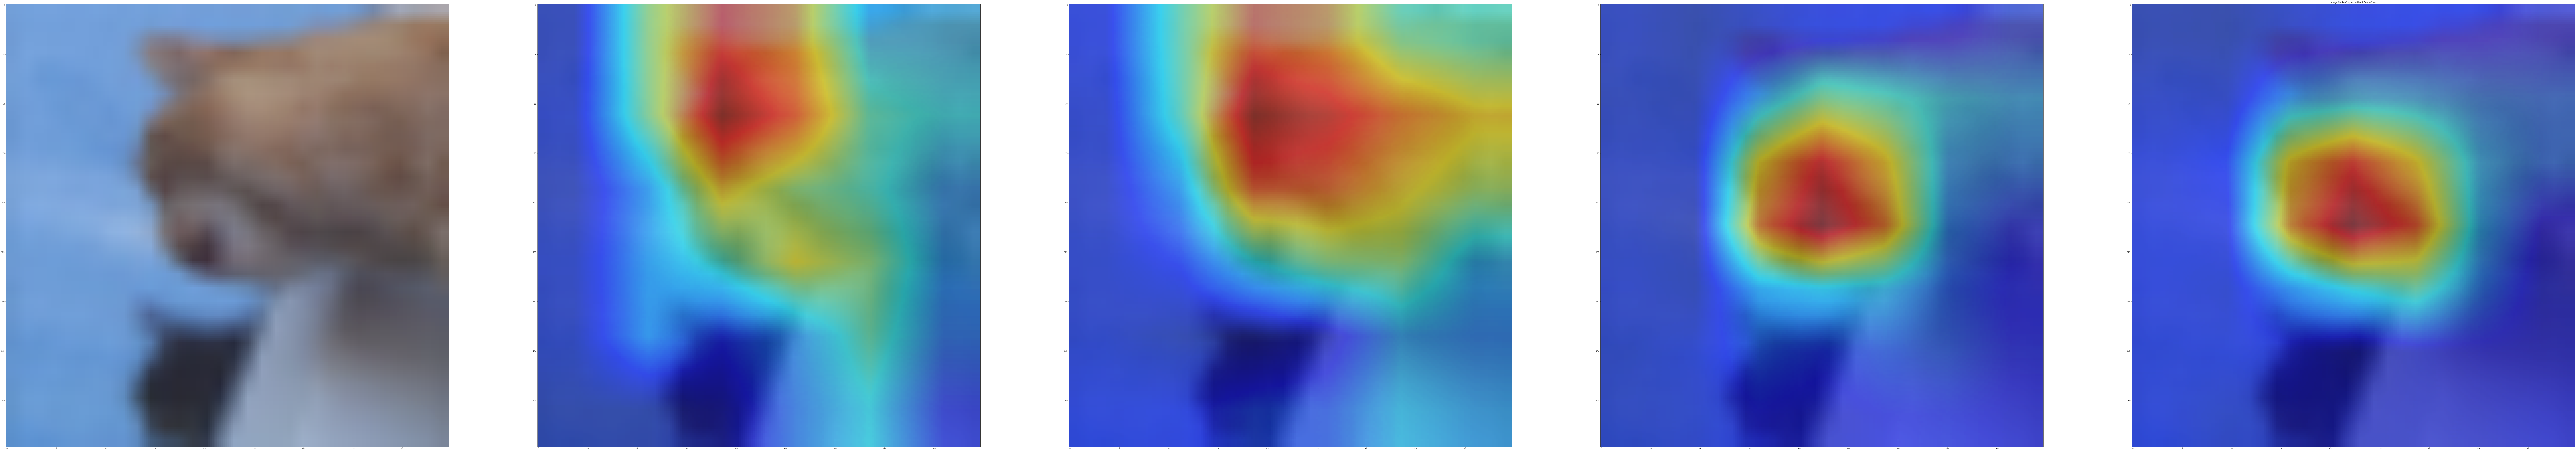

In [66]:
w=256
h=256
fig=plt.figure(figsize=(256, 256))
columns = 5
rows = 1
files = ["test_image.png","Alexnet_noCenterCrop.png","Alexnet_CenterCrop.png","VGG19_noCenterCrop.png","VGG19_CenterCrop.png"]
for i in range(1, columns*rows +1):
    img = files[i-1]#np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i)
    image = mpimg.imread(img)
    plt.imshow(image)
plt.title("Image CenterCrop vs. without CenterCrop")
plt.show()

Looking at these images it can be seen that centercropping the training images has only a very small impact on the resulting CAMs. The relevant parts of the test image are detected with and without centercropping.

## Pretrained weights vs. zero initialized weights

Execute the follwing code block to generate the CAM images.

In the code, we create four different models:
1. VGG19 (not Pretrained)
2. VGG19 (Pretrained)
3. Alexnet (not Pretrained)
4. Alexnet (Pretrained)

Basic procedure is the same as in chapter "Image Centercrop vs. without Centercrop"

In [67]:
unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
output_name = "test_image"
model_vgg19_notPretrained   = Vgg19()
mod_vgg19_notPretrained     = nn.Sequential(*list(model_vgg19_notPretrained.children())[:-1])

model_vgg19_pretrained   = Vgg19()
mod_vgg19_pretrained     = nn.Sequential(*list(model_vgg19_pretrained.children())[:-1])

model_alexnet_notPretrained   = Alexnet()
mod_alexnet_notPretrained     = nn.Sequential(*list(model_alexnet_notPretrained.children())[:-1])

model_alexnet_pretrained   = Alexnet()
mod_alexnet_pretrained     = nn.Sequential(*list(model_alexnet_pretrained.children())[:-1])

model_vgg19_notPretrained.load_state_dict(torch.load('DL_CIFAR/models/Pretraining/cifar_vgg_not_pretrained.pth', map_location='cpu'))
model_vgg19_pretrained.load_state_dict(torch.load('DL_CIFAR/models/Pretraining/cifar_vgg_pretrained.pth', map_location='cpu'))
model_alexnet_notPretrained.load_state_dict(torch.load('DL_CIFAR/models/Pretraining/alexnet_not_pretrained.pth', map_location='cpu'))
model_alexnet_pretrained.load_state_dict(torch.load('DL_CIFAR/models/Pretraining/alexnet_pretrained.pth', map_location='cpu'))

model_vgg19_notPretrained.eval()
model_vgg19_pretrained.eval()
model_alexnet_notPretrained.eval()
model_alexnet_pretrained.eval()

weight_softmax1 = model_vgg19_notPretrained.classifier.weight.detach().numpy()
weight_softmax2 = model_vgg19_pretrained.classifier.weight.detach().numpy()
weight_softmax3 = model_alexnet_notPretrained.classifier.weight.detach().numpy()
weight_softmax4 = model_alexnet_pretrained.classifier.weight.detach().numpy()

test_dataset = torchvision.datasets.CIFAR10("./testdata", train=False, download=True, transform=preprocessTestImages())
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)
test_iter = iter(test_loader)
images, labels = test_iter.next()

logit1 = model_vgg19_notPretrained(images)
logit2 = model_vgg19_pretrained(images)
logit3 = model_alexnet_notPretrained(images)
logit4 = model_alexnet_pretrained(images)

h_x1 = F.softmax(logit1, dim=1).data.squeeze()
h_x2 = F.softmax(logit2, dim=1).data.squeeze()
h_x3 = F.softmax(logit3, dim=1).data.squeeze()
h_x4 = F.softmax(logit4, dim=1).data.squeeze()

probs1, idx1 = h_x1.sort(0, True)
probs2, idx2 = h_x2.sort(0, True)
probs3, idx3 = h_x3.sort(0, True)
probs4, idx4 = h_x4.sort(0, True)

probs1 = probs1.detach().numpy()
idx1 = idx1.numpy()
probs2 = probs2.detach().numpy()
idx2 = idx2.numpy()
probs3 = probs3.detach().numpy()
idx3 = idx3.numpy()
probs4 = probs4.detach().numpy()
idx4 = idx4.numpy()

logitModel1 = logit1.cpu().detach().numpy()
logitModel2 = logit2.cpu().detach().numpy()
logitModel3 = logit3.cpu().detach().numpy()
logitModel4 = logit4.cpu().detach().numpy()

features_blobsA = mod_vgg19_notPretrained(images)
features_blobsB = mod_vgg19_pretrained(images)
features_blobsC = mod_alexnet_notPretrained(images)
features_blobsD = mod_alexnet_pretrained(images)

features_blobs1 = features_blobsA.cpu().detach().numpy()
features_blobs2 = features_blobsB.cpu().detach().numpy()
features_blobs3 = features_blobsC.cpu().detach().numpy()
features_blobs4 = features_blobsD.cpu().detach().numpy()

features_blobs1_avgpool = features_blobsA.view(512,7*7).mean(1).view(1,-1)
features_blobs2_avgpool = features_blobsB.view(512,7*7).mean(1).view(1,-1)
features_blobs3_avgpool = features_blobsC.view(256,6*6).mean(1).view(1,-1)
features_blobs4_avgpool = features_blobsD.view(256,6*6).mean(1).view(1,-1)

features_blobs1_avgpool = features_blobs1_avgpool.cpu().detach().numpy()
features_blobs2_avgpool = features_blobs2_avgpool.cpu().detach().numpy()
features_blobs3_avgpool = features_blobs3_avgpool.cpu().detach().numpy()
features_blobs4_avgpool = features_blobs4_avgpool.cpu().detach().numpy()

logitManual1 = np.matmul(features_blobs1_avgpool, weight_softmax1.transpose())
logitManual2 = np.matmul(features_blobs2_avgpool, weight_softmax2.transpose())
logitManual3 = np.matmul(features_blobs3_avgpool, weight_softmax3.transpose())
logitManual4 = np.matmul(features_blobs4_avgpool, weight_softmax4.transpose())

CAMs1 = returnCAM(features_blobs1, weight_softmax1, [idx1[0]])
CAMs2 = returnCAM(features_blobs2, weight_softmax2, [idx2[0]])
CAMs3 = returnCAM(features_blobs3, weight_softmax3, [idx3[0]])
CAMs4 = returnCAM(features_blobs4, weight_softmax4, [idx4[0]])

unnorm_image = unorm(images) # denormalized image
save_image(unnorm_image, output_name+'.png')

img1 = cv2.imread(output_name+'.png')
height, width, _ = img1.shape
heatmap1 = cv2.applyColorMap(cv2.resize(CAMs1[0],(width, height)), cv2.COLORMAP_JET)
result = heatmap1 * 0.5 + img1 * 0.5
saveImg = 'VGG19_notPretrained.png'
cv2.imwrite(saveImg, result)

img2 = cv2.imread(output_name+'.png')
height, width, _ = img2.shape
heatmap2 = cv2.applyColorMap(cv2.resize(CAMs2[0],(width, height)), cv2.COLORMAP_JET)
result = heatmap2 * 0.5 + img2 * 0.5
saveImg = 'VGG19_pretrained.png'
cv2.imwrite(saveImg, result)

img3 = cv2.imread(output_name+'.png')
height, width, _ = img3.shape
heatmap3 = cv2.applyColorMap(cv2.resize(CAMs3[0],(width, height)), cv2.COLORMAP_JET)
result = heatmap3 * 0.5 + img3 * 0.5
saveImg = 'Alexnet_notPretrained.png'
cv2.imwrite(saveImg, result)

img4 = cv2.imread(output_name+'.png')
height, width, _ = img4.shape
heatmap4 = cv2.applyColorMap(cv2.resize(CAMs4[0],(width, height)), cv2.COLORMAP_JET)
result = heatmap4 * 0.5 + img4 * 0.5
saveImg = 'Alexnet_pretrained.png'
cv2.imwrite(saveImg, result)

Files already downloaded and verified


True

### Visualize Results

Execute the following code block to get the CAMs visualized, after executing the previous block.

Column:
1. Original Image
2. not pretrained Alexnet
3. pretrained Alexnet
4. not pretrained VGG19
5. pretrained VGG19

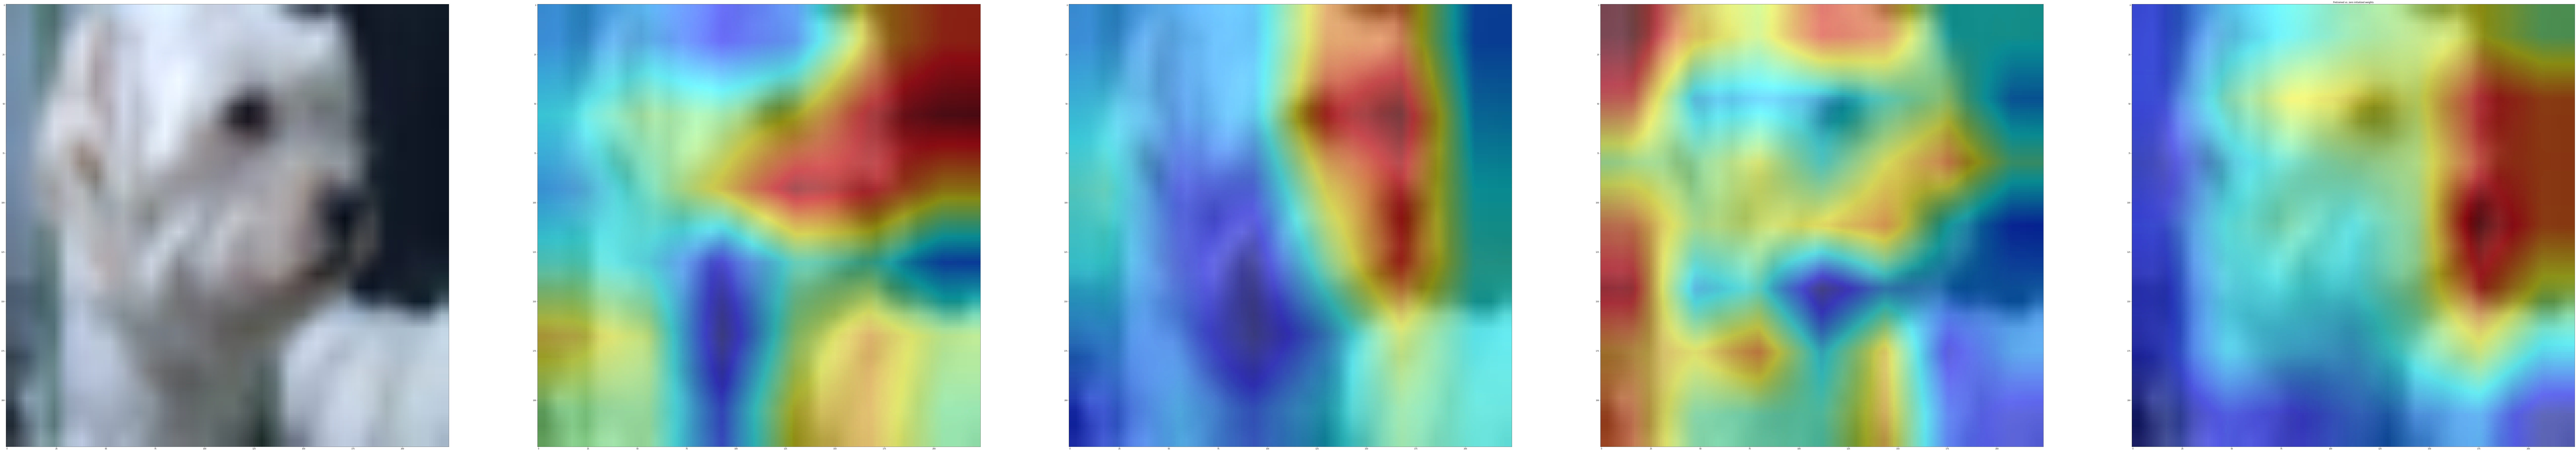

In [68]:
w=256
h=256
fig=plt.figure(figsize=(256, 256))
columns = 5
rows = 1
files = ["test_image.png","Alexnet_notPretrained.png","Alexnet_pretrained.png","VGG19_notPretrained.png","VGG19_pretrained.png"]
for i in range(1, columns*rows +1):
    img = files[i-1]#np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i)
    image = mpimg.imread(img)
    plt.imshow(image)
plt.title("Pretrained vs. zero initialized weights")
plt.show()

Comparing the pretrained Alexnet CAM output to the output of the non pretrained model autput, an improved detection of the bird in the image can be observed. The non pretrained model has a high activation in the upper right corner of the image although the bird is in the center of the image.

A similar improvement can be observed for the VGG19 models. For this model architecture, the improvement is even more significant.

## Freezing of different amount of layers

Execute the follwing code block to generate the CAM images.

In the code, we create four different models:
1. VGG19 (no freezed layers)
2. VGG19 (first 9 layers freezed)
3. VGG19 (first 18 layers freezed)
4. VGG19 (first 27 layers freezed)
5. Alexnet (no layers freezed)
6. Alexnet (first 3 layers freezed)
7. Alexnet (first 6 layers freezed)
8. Alexnet (first 9 layers freezed)

Basic procedure is the same as in chapter "Image Centercrop vs. without Centercrop"

In [69]:
unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
output_name = "test_image"
model_vgg19_freeze0   = Vgg19()
mod_vgg19_freeze0     = nn.Sequential(*list(model_vgg19_freeze0.children())[:-1])

model_vgg19_freeze1   = Vgg19()
mod_vgg19_freeze1     = nn.Sequential(*list(model_vgg19_freeze1.children())[:-1])

model_vgg19_freeze2   = Vgg19()
mod_vgg19_freeze2     = nn.Sequential(*list(model_vgg19_freeze2.children())[:-1])

model_vgg19_freeze3   = Vgg19()
mod_vgg19_freeze3     = nn.Sequential(*list(model_vgg19_freeze3.children())[:-1])

model_alexnet_freeze0 = Alexnet()
mod_alexnet_freeze0   = nn.Sequential(*list(model_alexnet_freeze0.children())[:-1])

model_alexnet_freeze1 = Alexnet()
mod_alexnet_freeze1   = nn.Sequential(*list(model_alexnet_freeze1.children())[:-1])

model_alexnet_freeze2 = Alexnet()
mod_alexnet_freeze2   = nn.Sequential(*list(model_alexnet_freeze2.children())[:-1])

model_alexnet_freeze3 = Alexnet()
mod_alexnet_freeze3   = nn.Sequential(*list(model_alexnet_freeze3.children())[:-1])
model_vgg19_freeze0.load_state_dict(torch.load('DL_CIFAR/models/freezing/cifar_vgg19_freeze0.pth', map_location='cpu'))
model_vgg19_freeze1.load_state_dict(torch.load('DL_CIFAR/models/freezing/cifar_vgg19_freeze9.pth', map_location='cpu'))
model_vgg19_freeze2.load_state_dict(torch.load('DL_CIFAR/models/freezing/cifar_vgg19_freeze18.pth', map_location='cpu'))
model_vgg19_freeze3.load_state_dict(torch.load('DL_CIFAR/models/freezing/cifar_vgg19_freeze27.pth', map_location='cpu'))
model_alexnet_freeze0.load_state_dict(torch.load('DL_CIFAR/models/freezing/cifar_alexnet_freeze0.pth', map_location='cpu'))
model_alexnet_freeze1.load_state_dict(torch.load('DL_CIFAR/models/freezing/cifar_alexnet_freeze1.pth', map_location='cpu'))
model_alexnet_freeze2.load_state_dict(torch.load('DL_CIFAR/models/freezing/cifar_alexnet_freeze2.pth', map_location='cpu'))
model_alexnet_freeze3.load_state_dict(torch.load('DL_CIFAR/models/freezing/cifar_alexnet_freeze3.pth', map_location='cpu'))
model_vgg19_freeze0.eval()
model_vgg19_freeze1.eval()
model_vgg19_freeze2.eval()
model_vgg19_freeze3.eval()
model_alexnet_freeze0.eval()
model_alexnet_freeze1.eval()
model_alexnet_freeze2.eval()
model_alexnet_freeze3.eval()
weight_softmax1 = model_vgg19_freeze0.classifier.weight.detach().numpy()
weight_softmax2 = model_vgg19_freeze1.classifier.weight.detach().numpy()
weight_softmax3 = model_vgg19_freeze2.classifier.weight.detach().numpy()
weight_softmax4 = model_vgg19_freeze3.classifier.weight.detach().numpy()
weight_softmax5 = model_alexnet_freeze0.classifier.weight.detach().numpy()
weight_softmax6 = model_alexnet_freeze1.classifier.weight.detach().numpy()
weight_softmax7 = model_alexnet_freeze2.classifier.weight.detach().numpy()
weight_softmax8 = model_alexnet_freeze3.classifier.weight.detach().numpy()

test_dataset = torchvision.datasets.CIFAR10("./testdata", train=False, download=True, transform=preprocessTestImages())
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)
test_iter = iter(test_loader)
images, labels = test_iter.next()

logit1 = model_vgg19_freeze0(images)
logit2 = model_vgg19_freeze1(images)
logit3 = model_vgg19_freeze2(images)
logit4 = model_vgg19_freeze3(images)
logit5 = model_alexnet_freeze0(images)
logit6 = model_alexnet_freeze1(images)
logit7 = model_alexnet_freeze2(images)
logit8 = model_alexnet_freeze3(images)
h_x1 = F.softmax(logit1, dim=1).data.squeeze()
h_x2 = F.softmax(logit2, dim=1).data.squeeze()
h_x3 = F.softmax(logit3, dim=1).data.squeeze()
h_x4 = F.softmax(logit4, dim=1).data.squeeze()
h_x5 = F.softmax(logit5, dim=1).data.squeeze()
h_x6 = F.softmax(logit6, dim=1).data.squeeze()
h_x7 = F.softmax(logit7, dim=1).data.squeeze()
h_x8 = F.softmax(logit8, dim=1).data.squeeze()

probs1, idx1 = h_x1.sort(0, True)
probs2, idx2 = h_x2.sort(0, True)
probs3, idx3 = h_x3.sort(0, True)
probs4, idx4 = h_x4.sort(0, True)
probs5, idx5 = h_x5.sort(0, True)
probs6, idx6 = h_x6.sort(0, True)
probs7, idx7 = h_x7.sort(0, True)
probs8, idx8 = h_x8.sort(0, True)

probs1 = probs1.detach().numpy()
idx1 = idx1.numpy()
probs2 = probs2.detach().numpy()
idx2 = idx2.numpy()
probs3 = probs3.detach().numpy()
idx3 = idx3.numpy()
probs4 = probs4.detach().numpy()
idx4 = idx4.numpy()
probs5 = probs5.detach().numpy()
idx5 = idx5.numpy()
probs6 = probs6.detach().numpy()
idx6 = idx6.numpy()
probs7 = probs7.detach().numpy()
idx7 = idx7.numpy()
probs8 = probs8.detach().numpy()
idx8 = idx8.numpy()

logitModel1 = logit1.cpu().detach().numpy()
logitModel2 = logit2.cpu().detach().numpy()
logitModel3 = logit3.cpu().detach().numpy()
logitModel4 = logit4.cpu().detach().numpy()
logitModel5 = logit5.cpu().detach().numpy()
logitModel6 = logit6.cpu().detach().numpy()
logitModel7 = logit7.cpu().detach().numpy()
logitModel8 = logit8.cpu().detach().numpy()

features_blobsA = mod_vgg19_freeze0(images)
features_blobsB = mod_vgg19_freeze1(images)
features_blobsC = mod_vgg19_freeze2(images)
features_blobsD = mod_vgg19_freeze3(images)
features_blobsE = mod_alexnet_freeze0(images)
features_blobsF = mod_alexnet_freeze1(images)
features_blobsG = mod_alexnet_freeze2(images)
features_blobsH = mod_alexnet_freeze3(images)

features_blobs1 = features_blobsA.cpu().detach().numpy()
features_blobs2 = features_blobsB.cpu().detach().numpy()
features_blobs3 = features_blobsC.cpu().detach().numpy()
features_blobs4 = features_blobsD.cpu().detach().numpy()
features_blobs5 = features_blobsE.cpu().detach().numpy()
features_blobs6 = features_blobsF.cpu().detach().numpy()
features_blobs7 = features_blobsG.cpu().detach().numpy()
features_blobs8 = features_blobsH.cpu().detach().numpy()

features_blobs1_avgpool = features_blobsA.view(512,7*7).mean(1).view(1,-1)
features_blobs2_avgpool = features_blobsB.view(512,7*7).mean(1).view(1,-1)
features_blobs3_avgpool = features_blobsC.view(512,7*7).mean(1).view(1,-1)
features_blobs4_avgpool = features_blobsD.view(512,7*7).mean(1).view(1,-1)
features_blobs5_avgpool = features_blobsE.view(256,6*6).mean(1).view(1,-1)
features_blobs6_avgpool = features_blobsF.view(256,6*6).mean(1).view(1,-1)
features_blobs7_avgpool = features_blobsG.view(256,6*6).mean(1).view(1,-1)
features_blobs8_avgpool = features_blobsH.view(256,6*6).mean(1).view(1,-1)

features_blobs1_avgpool = features_blobs1_avgpool.cpu().detach().numpy()
features_blobs2_avgpool = features_blobs2_avgpool.cpu().detach().numpy()
features_blobs3_avgpool = features_blobs3_avgpool.cpu().detach().numpy()
features_blobs4_avgpool = features_blobs4_avgpool.cpu().detach().numpy()
features_blobs5_avgpool = features_blobs5_avgpool.cpu().detach().numpy()
features_blobs6_avgpool = features_blobs6_avgpool.cpu().detach().numpy()
features_blobs7_avgpool = features_blobs7_avgpool.cpu().detach().numpy()
features_blobs8_avgpool = features_blobs8_avgpool.cpu().detach().numpy()

logitManual1 = np.matmul(features_blobs1_avgpool, weight_softmax1.transpose())
logitManual2 = np.matmul(features_blobs2_avgpool, weight_softmax2.transpose())
logitManual3 = np.matmul(features_blobs3_avgpool, weight_softmax3.transpose())
logitManual4 = np.matmul(features_blobs4_avgpool, weight_softmax4.transpose())
logitManual5 = np.matmul(features_blobs5_avgpool, weight_softmax5.transpose())
logitManual6 = np.matmul(features_blobs6_avgpool, weight_softmax6.transpose())
logitManual7 = np.matmul(features_blobs7_avgpool, weight_softmax7.transpose())
logitManual8 = np.matmul(features_blobs8_avgpool, weight_softmax8.transpose())

CAMs1 = returnCAM(features_blobs1, weight_softmax1, [idx1[0]])
CAMs2 = returnCAM(features_blobs2, weight_softmax2, [idx2[0]])
CAMs3 = returnCAM(features_blobs3, weight_softmax3, [idx3[0]])
CAMs4 = returnCAM(features_blobs4, weight_softmax4, [idx4[0]])
CAMs5 = returnCAM(features_blobs5, weight_softmax5, [idx5[0]])
CAMs6 = returnCAM(features_blobs6, weight_softmax6, [idx6[0]])
CAMs7 = returnCAM(features_blobs7, weight_softmax7, [idx7[0]])
CAMs8 = returnCAM(features_blobs8, weight_softmax8, [idx8[0]])

unnorm_image = unorm(images) # denormalized image
save_image(unnorm_image, output_name+'.png')

img1 = cv2.imread(output_name+'.png')
height, width, _ = img1.shape
heatmap1 = cv2.applyColorMap(cv2.resize(CAMs1[0],(width, height)), cv2.COLORMAP_JET)
result = heatmap1 * 0.5 + img1 * 0.5
saveImg = 'VGG19_freeze0.png'
cv2.imwrite(saveImg, result)

img2 = cv2.imread(output_name+'.png')
height, width, _ = img2.shape
heatmap2 = cv2.applyColorMap(cv2.resize(CAMs2[0],(width, height)), cv2.COLORMAP_JET)
result = heatmap2 * 0.5 + img2 * 0.5
saveImg = 'VGG19_freeze1.png'
cv2.imwrite(saveImg, result)

img3 = cv2.imread(output_name+'.png')
height, width, _ = img3.shape
heatmap3 = cv2.applyColorMap(cv2.resize(CAMs3[0],(width, height)), cv2.COLORMAP_JET)
result = heatmap3 * 0.5 + img3 * 0.5
saveImg = 'VGG19_freeze2.png'
cv2.imwrite(saveImg, result)

img4 = cv2.imread(output_name+'.png')
height, width, _ = img4.shape
heatmap4 = cv2.applyColorMap(cv2.resize(CAMs4[0],(width, height)), cv2.COLORMAP_JET)
result = heatmap4 * 0.5 + img4 * 0.5
saveImg = 'VGG19_freeze3.png'
cv2.imwrite(saveImg, result)

img5 = cv2.imread(output_name+'.png')
height, width, _ = img5.shape
heatmap5 = cv2.applyColorMap(cv2.resize(CAMs5[0],(width, height)), cv2.COLORMAP_JET)
result = heatmap5 * 0.5 + img5 * 0.5
saveImg = 'Alexnet_freeze0.png'
cv2.imwrite(saveImg, result)

img6 = cv2.imread(output_name+'.png')
height, width, _ = img6.shape
heatmap6 = cv2.applyColorMap(cv2.resize(CAMs6[0],(width, height)), cv2.COLORMAP_JET)
result = heatmap6 * 0.5 + img6 * 0.5
saveImg = 'Alexnet_freeze1.png'
cv2.imwrite(saveImg, result)

img7 = cv2.imread(output_name+'.png')
height, width, _ = img7.shape
heatmap7 = cv2.applyColorMap(cv2.resize(CAMs7[0],(width, height)), cv2.COLORMAP_JET)
result = heatmap7 * 0.5 + img7 * 0.5
saveImg = 'Alexnet_freeze2.png'
cv2.imwrite(saveImg, result)

img8 = cv2.imread(output_name+'.png')
height, width, _ = img8.shape
heatmap8 = cv2.applyColorMap(cv2.resize(CAMs8[0],(width, height)), cv2.COLORMAP_JET)
result = heatmap8 * 0.5 + img8 * 0.5
saveImg = 'Alexnet_freeze3.png'
cv2.imwrite(saveImg, result)

Files already downloaded and verified


True

### Visualize Results

Execute the following code block to get the CAMs visualized, after executing the previous block.

Column:
1.   Original Image
2.   No Layer Freezing applied
3.   First 1/4 layers freezed
4.   First 1/2 layers freezed
5.   First 3/4 layers freezed

Row:
1. Alexnet
2. VGG19

In [70]:
w=256
h=256
fig=plt.figure(figsize=(256, 128))
columns = 5
rows = 2
files = ["test_image.png","Alexnet_freeze0.png","Alexnet_freeze1.png","Alexnet_freeze2.png","Alexnet_freeze3.png","test_image.png","VGG19_freeze0.png","VGG19_freeze1.png","VGG19_freeze2.png","VGG19_freeze3.png"]
for i in range(1, columns*rows +1):
    img = files[i-1]#np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i)
    image = mpimg.imread(img)
    plt.imshow(image)
plt.title("Freezing of different amount of layers")
plt.show()

Alexnet architecture:
- a model with no layer freezing applied does not seem to recognize the essential features of the picture yet
- a model with 1/4 of the layers freezed captures the relevant image regions much better
- a model with 1/2 of the layers freezed achieves almost the same precision as the previous model, but the area of high activation is a little smaller. It captures almost exactly the head of the horse
- a model with 3/4 of the layers freezed results in a strong shift of the area of high activation and the model seems to focus more on the background than on the horse itself

VGG19 architecture:
- a model with no layer freezing applied shows comparatively good results. It seems to capture the head of the horse better than any Alexnet model
- a model with 1/4 of the layers freezed shows a wider area of activation but there is almost no difference to the previous model
- a model with 1/2 of the layers freezed is also similar to the previous model but with a little smaller area of high activation
- a model with 3/4 of the layers freezed shows a drastic shift in direction of the neck of the horse. Also the area of high activation gets much bigger and the model does not seem to capture the relevant parts of the head of the horse anymore